In [21]:
# -*- coding: utf-8 -*-
# ================================================================
# Part 3: Scalability Study

# pip install numpy pandas matplotlib tqdm joblib numba
# ================================================================

import math, time, itertools
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional, Literal, Sequence
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")


# Optional: numba-accelerated reducer (safe fallback if not installed)
try:
    from numba import njit
    HAVE_NUMBA = True
except ImportError:
    HAVE_NUMBA = False
    # Define a placeholder decorator if numba is not installed
    def njit(func):
        return func

# ---------------- Global configs ----------------
RESULTS_DIR = Path("results_scalability")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
EPS = 1e-9

# ================================================================
# 1) Lightweight graph utils
# ================================================================
@dataclass
class Graph:
    """Undirected simple graph with designated s, t terminals."""
    n_nodes: int
    edges: List[Tuple[int,int]]
    s: int
    t: int
    def adj(self) -> List[List[int]]:
        g = [[] for _ in range(self.n_nodes)]
        for u,v in self.edges:
            g[u].append(v); g[v].append(u)
        return g

def er_graph(n_nodes: int, p_edge: float, rng: np.random.Generator, max_tries: int = 50) -> Graph:
    """Erdős–Rényi G(n, p) but ensure s-t connectivity (retry, then fallback to path)."""
    for _ in range(max_tries):
        edges = []
        for u in range(n_nodes):
            for v in range(u+1, n_nodes):
                if rng.random() < p_edge: edges.append((u,v))
        if not edges: continue
        s, t = int(rng.integers(0, n_nodes)), int(rng.integers(0, n_nodes))
        if s == t: t = (t+1) % n_nodes
        adj = [[] for _ in range(n_nodes)];
        for u,v in edges: adj[u].append(v); adj[v].append(u)
        seen, q = {s}, [s]
        head = 0
        while head < len(q):
            x = q[head]; head += 1
            for y in adj[x]:
                if y not in seen: seen.add(y); q.append(y)
        if t in seen: return Graph(n_nodes, edges, s, t)
    edges = [(i, i+1) for i in range(n_nodes-1)]
    return Graph(n_nodes, edges, 0, n_nodes-1)

def grid_graph(r: int, c: int) -> Graph:
    def idx(x,y): return x*c + y
    edges = []
    for x in range(r):
        for y in range(c):
            if x+1 < r: edges.append((idx(x,y), idx(x+1,y)))
            if y+1 < c: edges.append((idx(x,y), idx(x,y+1)))
    return Graph(r*c, edges, 0, r*c-1)

def build_edge_index(graph: Graph) -> Dict[Tuple[int,int], int]:
    norm = lambda a,b: (a,b) if a<b else (b,a)
    return {norm(u,v): idx for idx,(u,v) in enumerate(graph.edges)}

def path_to_edge_tuple(path_nodes, edge_idx):
    norm = lambda a,b: (a,b) if a<b else (b,a)
    out = []
    for u,v in zip(path_nodes[:-1], path_nodes[1:]):
        key = norm(u,v)
        assert key in edge_idx, f"Edge {key} not in edge_idx (graph/path mismatch)."
        out.append(edge_idx[key])
    return tuple(out)

def sample_st_paths(graph: Graph, max_len: int, max_paths: int, rng: np.random.Generator) -> List[Tuple[int,...]]:
    adj, s, t = graph.adj(), graph.s, graph.t
    paths = []
    stack = [(s, [s])]
    while stack and len(paths) < max_paths:
        node, path = stack.pop()
        if len(path) > max_len: continue
        if node == t: paths.append(tuple(path)); continue
        nbrs = adj[node][:]; rng.shuffle(nbrs)
        for v in nbrs:
            if v not in path: stack.append((v, path+[v]))
    return paths

# ================================================================
# 2) Instance definition
# ================================================================
@dataclass
class Instance:
    n: int
    d: int
    weights: np.ndarray
    a_coeffs: np.ndarray
    strategies: List[List[Tuple[int,...]]]
    graph_name: str
    p_participation: float

def generate_instance_from_topology(
    topology: str, n_players: int, d: int, k_per_player: int,
    rng: np.random.Generator, p_participation: float, topo_params: Dict[str,Any]
) -> Instance:
    if topology == "ER":
        g = er_graph(topo_params["n_nodes"], topo_params["p_edge"], rng)
        gname = f"ER(n={topo_params['n_nodes']},p={topo_params['p_edge']})"
    elif topology == "Grid":
        r, c = topo_params.get("r", 5), topo_params.get("c", 5)
        g = grid_graph(r, c)
        gname = f"Grid({r}x{c})"
    else: raise ValueError(f"Unknown topology: {topology}")

    edge_idx = build_edge_index(g)
    raw_paths = sample_st_paths(g, max_len=12, max_paths=1000, rng=rng)
    if not raw_paths: raw_paths = [tuple([g.s, g.t])]
    edge_paths = list(dict.fromkeys([path_to_edge_tuple(p, edge_idx) for p in raw_paths]))
    while len(edge_paths) < k_per_player: edge_paths.append(edge_paths[-1])

    strategies = []
    for _ in range(n_players):
        idxs = rng.choice(len(edge_paths), size=k_per_player, replace=len(edge_paths)<k_per_player)
        strategies.append([edge_paths[i] for i in idxs])

    return Instance(
        n=n_players, d=d, weights=rng.uniform(0.5, 2.0, size=n_players),
        a_coeffs=rng.uniform(0.5, 1.5, size=len(g.edges)),
        strategies=strategies, graph_name=gname, p_participation=p_participation
    )

# ================================================================
# 3) Expected cost functions (vectorized PS; SV with CRN + perm-bank)
# ================================================================
def _build_incidence_matrix(inst: Instance, profile: Tuple[int,...]) -> np.ndarray:
    n, m = inst.n, len(inst.a_coeffs)
    B = np.zeros((n, m), dtype=np.int8)
    for i in range(n):
        path = inst.strategies[i][profile[i]]
        if path: B[i, list(path)] = 1
    return B

def _moments_weighted_bernoulli(weights: np.ndarray, p: float, kmax: int) -> np.ndarray:
    """

    """
    coeff = np.zeros(kmax + 1, dtype=float)
    coeff[0] = 1.0  # 
    for w in weights:
        # 
        fact = np.zeros(kmax + 1, dtype=float)
        fact[0] = 1.0
        pw = 1.0
        for r in range(1, kmax + 1):
            pw *= w
            fact[r] = p * (pw / math.factorial(r))
        # 
        newc = np.zeros_like(coeff)
        for r in range(kmax + 1):
            s = 0.0
            for i in range(r + 1):
                s += coeff[i] * fact[r - i]
            newc[r] = s
        coeff = newc
    # M_k = k! * [t^k]G(t)
    return np.array([math.factorial(k) * coeff[k] for k in range(kmax + 1)], dtype=float)

def expected_costs_ps_moment(inst, profile, p):
    """

    """
    n, d, w = inst.n, inst.d, inst.weights
    B = _build_incidence_matrix(inst, profile).astype(bool)  # n x m
    a = inst.a_coeffs
    m_edges = B.shape[1]

    player_costs = np.zeros(n, dtype=float)
    social_cost = 0.0

    for e in range(m_edges):
        loc = np.flatnonzero(B[:, e])
        if loc.size == 0:
            continue
        wloc = w[loc]

        #  a_e * E[S_e^d]
        Md = _moments_weighted_bernoulli(wloc, p, d)[d]
        social_cost += a[e] * Md

        #  a_e * w_i * p * sum_{k=0}^{d-1} C(d-1,k) w_i^{d-1-k} * E[S_{-i}^k]
        if loc.size == 1:
            i = int(loc[0])
            player_costs[i] += a[e] * p * (w[i] ** d)
            continue

    
        for pos, i in enumerate(loc):
            wi = float(w[i])
            others = np.delete(wloc, pos)
            M_ex = _moments_weighted_bernoulli(others, p, d - 1)
            s = 0.0
            # Σ_{k=0}^{d-1} C(d-1,k) * wi^{d-1-k} * M_ex[k]
            pw = 1.0
         
            for k in range(0, d):
                s += math.comb(d - 1, k) * (wi ** (d - 1 - k)) * M_ex[k]
            player_costs[i] += a[e] * wi * p * s

 
    return {"player_costs": player_costs, "social_cost": float(social_cost)}


def expected_costs_ps(inst, profile, types_mode, p, *, K_types=1000, rng=None, types_bank=None):
    if rng is None: rng = np.random.default_rng()
    n, d, w = inst.n, inst.d, inst.weights
    B = _build_incidence_matrix(inst, profile)
    player_costs = np.zeros(n, dtype=float)

    if types_mode == "exact" and n <= 12 and types_bank is None:
        for mask in range(1<<n):
            k = mask.bit_count()
            prob = (p**k) * ((1-p)**(n-k))
            if prob < 1e-16: continue
            active = np.array([(mask>>i)&1 for i in range(n)], dtype=bool)
            if not np.any(active): continue

            w_active = w * active
            total_w_e = B.T @ w_active
            edge_costs = inst.a_coeffs * np.power(total_w_e, d)

            inv_total_w = np.zeros_like(total_w_e, dtype=float)              # NEW
            np.divide(1.0, total_w_e, out=inv_total_w, where=total_w_e>EPS)  # NEW

            player_shares = B @ (edge_costs * inv_total_w)
            player_costs += prob * player_shares * w_active                   # NEW
    else:
        T = types_bank if types_bank is not None else (rng.random((K_types, n)) < p)
        denom = len(T)
        for active in T:
            if not np.any(active): continue
            w_active = w * active                                            # NEW
            total_w_e = B.T @ w_active
            edge_costs = inst.a_coeffs * np.power(total_w_e, d)

            inv_total_w = np.zeros_like(total_w_e, dtype=float)              # NEW
            np.divide(1.0, total_w_e, out=inv_total_w, where=total_w_e>EPS)  # NEW

            player_shares = B @ (edge_costs * inv_total_w)
            player_costs += player_shares * w_active                          # NEW
        player_costs /= denom

    return {"player_costs": player_costs, "social_cost": float(player_costs.sum())}


def _sv_edge_shares_exact(weights_e: np.ndarray, a_e: float, d: int) -> np.ndarray:
    m = len(weights_e)
    if m == 0: return np.zeros(0, dtype=float)
    if d == 2: return a_e * weights_e * float(weights_e.sum())
    shares = np.zeros(m, dtype=float)
    for perm in itertools.permutations(range(m)):
        prefix = 0.0
        for j in perm:
            wj = float(weights_e[j])
            shares[j] += a_e * ((prefix + wj)**d - (prefix**d))
            prefix += wj
    shares /= math.factorial(m)
    return shares

class PermBank:
    def __init__(self, rng: np.random.Generator): self.rng = rng; self.cache = {}
    def get(self, m: int, K_perm: int) -> np.ndarray:
        key = (m, K_perm)
        if key not in self.cache:
            self.cache[key] = np.stack([self.rng.permutation(m) for _ in range(K_perm)])
        return self.cache[key]

@njit
def _sv_shares_from_perms_numba(weights_e: np.ndarray, a_e: float, d: int, perms: np.ndarray) -> np.ndarray:
    K, m = perms.shape
    total = np.zeros(m, dtype=np.float64)
    for k in range(K):
        prefix = 0.0
        for pos in range(m):
            j = perms[k, pos]
            wj = weights_e[j]
            total[j] += a_e * ((prefix + wj)**d - prefix**d)
            prefix += wj
    return total / K

@njit(cache=True, fastmath=True)   
def _sv_shares_from_perms_numba(weights_e: np.ndarray, a_e: float, d: int, perms: np.ndarray) -> np.ndarray:
    K, m = perms.shape
    total = np.zeros(m, dtype=np.float64)
    for k in range(K):
        prefix = 0.0
        for pos in range(m):
            j = perms[k, pos]
            wj = weights_e[j]
            total[j] += a_e * ((prefix + wj)**d - prefix**d)
            prefix += wj
    return total / K

def expected_costs_sv(
    inst: Instance, profile: Tuple[int,...], types_mode: Literal["exact","mc"], p: float,
    *, K_types: int = 1000, K_perm: int = 120, exact_perm_threshold: int = 6,
    rng: Optional[np.random.Generator] = None,
    types_bank: Optional[np.ndarray] = None, perm_bank: Optional[PermBank] = None,
    
    approx_large_m: bool = True, m_large: int = 12
) -> Dict[str,Any]:
    if rng is None: rng = np.random.default_rng()
    if perm_bank is None: perm_bank = PermBank(rng)
    n, d, w, a = inst.n, inst.d, inst.weights, inst.a_coeffs

    
    B = _build_incidence_matrix(inst, profile).astype(bool)
    m_edges = B.shape[1]

    def contrib_for_active_mask(active_mask: np.ndarray) -> np.ndarray:
        contrib = np.zeros(n, dtype=float)
        for e in range(m_edges):
            loc_mask = active_mask & B[:, e]
            mloc = int(loc_mask.sum())
            if mloc == 0:
                continue
            loc = np.flatnonzero(loc_mask)
            wloc = w[loc]
            if mloc == 1:
                # 单人边：Shapley=全额
                contrib[loc[0]] += float(a[e]) * float(wloc[0] ** d)
                continue
            if d == 2 or mloc <= exact_perm_threshold:
                shares = _sv_edge_shares_exact(wloc, float(a[e]), d)
                contrib[loc] += shares
                continue
            # 大 m 用近似（Aumann–Shapley ≡ PS；对 x^d 是 a * w_i * W^{d-1}）
            if approx_large_m and mloc >= m_large:
                W = float(wloc.sum())
                if W > 0.0:
                    contrib[loc] += float(a[e]) * wloc * (W ** (d - 1))
                continue
            # 中等 m：少量排列采样（Numba）
            K_eff = min(K_perm, 10 + 2 * mloc)
            perms = perm_bank.get(mloc, K_eff)
            shares = _sv_shares_from_perms_numba(wloc.astype(np.float64), float(a[e]), d, perms)
            contrib[loc] += shares
        return contrib

    if types_mode == "exact" and n <= 12 and types_bank is None:
        total_costs = np.zeros(n, dtype=float)
        for mask in range(1<<n):
            k = mask.bit_count()
            prob = (p**k) * ((1-p)**(n-k))
            if prob < 1e-16:     # ← 与 PS 对齐，避免偏差
                continue
            if k == 0:
                continue
            active_mask = np.fromiter(((mask>>i)&1 for i in range(n)), dtype=bool, count=n)
            total_costs += prob * contrib_for_active_mask(active_mask)
    else:
        T = types_bank if types_bank is not None else (rng.random((K_types, n)) < p)
        total_costs = np.zeros(n, dtype=float)
        for active in T:
            if not np.any(active):
                continue
            total_costs += contrib_for_active_mask(active)
        total_costs /= len(T)

    return {"player_costs": total_costs, "social_cost": float(total_costs.sum())}

# ================================================================
# 4) BRD and approximate OPT
# ================================================================
def make_types_bank(n: int, K_types: int, p: float, rng: np.random.Generator) -> np.ndarray:
    """Pre-sample type vectors (CRN) and reuse them within a BRD/OPT run."""
    return (rng.random((K_types, n)) < p)

def run_brd(
    inst: Instance, rule: Literal["PS","SV"], p: float,
    *, max_rounds: int = 400, stable_rounds_needed: int = 1,
    types_mode: Literal["exact","mc"] = "mc",
    K_types: int = 200, K_perm: int = 120, exact_perm_threshold: int = 6,
    rng: Optional[np.random.Generator] = None
) -> Dict[str,Any]:
    """Async random-sweep BRD with cycle detection and memo cache."""
    if rng is None: rng = np.random.default_rng()
    n = inst.n
    profile = tuple(rng.integers(0, len(inst.strategies[i])) for i in range(n))
    visited = {profile}
    t0 = time.perf_counter()
    stable = 0
    # CRN banks
    types_bank = make_types_bank(n, K_types, p, rng) if types_mode == "mc" else None
    perm_bank = PermBank(rng)
    # memo
    cache: Dict[Tuple[int,...], Tuple[np.ndarray, float]] = {}

    def eval_costs(prof: Tuple[int,...]) -> Tuple[np.ndarray, float]:
        if prof in cache:
            return cache[prof]
        if rule == "PS":
            out = expected_costs_ps_moment(inst, prof, p)
        else:
            out = expected_costs_sv(inst, prof, types_mode, p, K_types=K_types, K_perm=K_perm,
                                   exact_perm_threshold=exact_perm_threshold, rng=rng,
                                   types_bank=types_bank, perm_bank=perm_bank)
        cache[prof] = (out["player_costs"], out["social_cost"])
        return cache[prof]

    iters = 0
    for r in range(1, max_rounds+1):
        changed = False
        for i in rng.permutation(n):
            base_costs, _ = eval_costs(profile)
            best_s, best_val = profile[i], base_costs[i]
            k = len(inst.strategies[i])
            for s in range(k):
                if s == profile[i]: 
                    continue
                cand = list(profile); cand[i] = s; cand = tuple(cand)
                pc, _ = eval_costs(cand)
                if pc[i] + EPS < best_val:
                    best_val, best_s = pc[i], s
            iters += 1
            if best_s != profile[i]:
                new_prof = list(profile); new_prof[i] = best_s; new_prof = tuple(new_prof)
                if new_prof in visited:
                    return {"status":"CYCLE","rounds":r,"iters":iters,"time_sec":time.perf_counter()-t0,"profile":new_prof}
                visited.add(new_prof)
                profile = new_prof
                changed = True
        if not changed:
            stable += 1
            if stable >= stable_rounds_needed:
                return {"status":"CONVERGED","rounds":r,"iters":iters,"time_sec":time.perf_counter()-t0,"profile":profile}
        else:
            stable = 0
    return {"status":"MAX_ROUNDS","rounds":max_rounds,"iters":iters,"time_sec":time.perf_counter()-t0,"profile":profile}

def approx_opt_profile(
    inst: Instance, rule: Literal["PS","SV"], p: float,
    *, restarts: int = 3, sweeps: int = 4,
    types_mode: Literal["exact","mc"] = "mc",
    K_types: int = 300, K_perm: int = 120, exact_perm_threshold: int = 6,
    rng: Optional[np.random.Generator] = None
) -> Dict[str,Any]:
    """Greedy coordinate descent on social cost with multiple restarts."""
    if rng is None: rng = np.random.default_rng()
    n = inst.n
    best = {"social": np.inf, "profile": None, "time_sec": 0.0}
    t0 = time.perf_counter()

    for _ in range(restarts):
        profile = tuple(rng.integers(0, len(inst.strategies[i])) for i in range(n))
        improved = True
        # CRN per restart
        types_bank = make_types_bank(n, K_types, p, rng) if types_mode == "mc" else None
        perm_bank = PermBank(rng)

        def eval_social(prof: Tuple[int,...]) -> float:
            if rule == "PS":
                return expected_costs_ps_moment(inst, prof, p)["social_cost"]
            else:
                return expected_costs_sv(inst, prof, types_mode, p, K_types=K_types, K_perm=K_perm,
                                         exact_perm_threshold=exact_perm_threshold, rng=rng,
                                         types_bank=types_bank, perm_bank=perm_bank)["social_cost"]

        cur = eval_social(profile)
        for _s in range(sweeps):
            improved = False
            for i in rng.permutation(n):
                k = len(inst.strategies[i])
                best_i_s, best_i_val = profile[i], cur
                for s in range(k):
                    if s == profile[i]: 
                        continue
                    cand = list(profile); cand[i] = s; cand = tuple(cand)
                    val = eval_social(cand)
                    if val + EPS < best_i_val:
                        best_i_val, best_i_s = val, s
                if best_i_s != profile[i]:
                    profile = tuple(list(profile[:i]) + [best_i_s] + list(profile[i+1:]))
                    cur = best_i_val
                    improved = True
            if not improved:
                break

        if cur < best["social"]:
            best.update({"social": cur, "profile": profile})

    best["time_sec"] = time.perf_counter() - t0
    return best

# ================================================================
# 5) Per-instance evaluation & parallel sweep
# ================================================================
def evaluate_instance(
    inst_params: Dict[str,Any], seed: int, *, eval_sv: bool = False
) -> List[Dict[str,Any]]:
    rng = np.random.default_rng(seed)
    inst = generate_instance_from_topology(rng=rng, **inst_params)
    p = inst.p_participation
    ps_types_mode = "mc" 
    
    # Run BRD for PS
    brd_report = run_brd(inst, "PS", p, types_mode=ps_types_mode, K_types=200, rng=rng)
    opt_report = approx_opt_profile(inst, "PS", p, types_mode=ps_types_mode, K_types=300, rng=rng)
    
    soc_brd_ps = expected_costs_ps(inst, brd_report["profile"], ps_types_mode, p, K_types=300, rng=rng)["social_cost"]
    soc_opt_ps = opt_report["social"]
    poa_ps = soc_brd_ps / soc_opt_ps if soc_opt_ps > 0 else np.nan

    out_rows = [{
        "graph": inst.graph_name, "n": inst.n, "d": inst.d, "p": p, "rule": "PS",
        "status": brd_report["status"], "poa": poa_ps, "time_brd_sec": brd_report["time_sec"],
        "time_opt_sec": opt_report["time_sec"], "iters_brd": brd_report.get("iters", np.nan)
    }]
    # Placeholder for SV logic
    return out_rows

def run_scalability_sweep(
    *, n_list: Sequence[int] = (5, 10, 20), p_list: Sequence[float] = (0.5, 0.9),
    d: int = 3, k_per_player: int = 3,
    topologies: Sequence[Tuple[str, Dict[str,Any]]] = (("ER", {"n_nodes": 40, "p_edge": 0.3}),),
    instances_each: int = 10, eval_sv: bool = False, seed: int = 2025
) -> pd.DataFrame:
    master = np.random.default_rng(seed)
    tasks = []
    for n in n_list:
        for p in p_list:
            for topo_name, tparams in topologies:
                for _ in range(instances_each):
                    inst_params = {
                        "topology": topo_name, "n_players": n, "d": d,
                        "k_per_player": k_per_player, "p_participation": p, "topo_params": tparams
                    }
                    task_seed = int(master.integers(0, 2**31 - 1))
                    tasks.append(delayed(evaluate_instance)(inst_params, task_seed, eval_sv=eval_sv))

    print(f"[Sweep] Starting {len(tasks)} tasks in parallel...")
    results_list = Parallel(n_jobs=-1, prefer="threads")(tasks)
    rows = [row for item in results_list for row in item]
    return pd.DataFrame(rows)


from datetime import datetime
import json


def degree_bounded_graph(n_nodes: int, max_deg: int, rng: np.random.Generator) -> Graph:

    
    nodes = list(range(n_nodes))
    rng.shuffle(nodes)
    parent = {nodes[0]: -1}
    edges = []
    for v in nodes[1:]:
        u = int(rng.choice(list(parent.keys())))
        edges.append((u, v))
        parent[v] = u
    
    deg = {i: 0 for i in range(n_nodes)}
    for u, v in edges:
        deg[u] += 1; deg[v] += 1
    
    trials = 5 * n_nodes * max(1, max_deg)
    for _ in range(trials):
        u = int(rng.integers(0, n_nodes)); v = int(rng.integers(0, n_nodes))
        if u == v: continue
        a, b = (u, v) if u < v else (v, u)
        if (a, b) in {(min(x, y), max(x, y)) for x, y in edges}: 
            continue
        if deg[u] >= max_deg or deg[v] >= max_deg:
            continue
        edges.append((a, b))
        deg[u] += 1; deg[v] += 1
    
    s, t = 0, n_nodes - 1
    return Graph(n_nodes, edges, s, t)

def ladder_graph(L: int) -> Graph:
    
    edges = []
   
    for i in range(L - 1):
        edges.append((i, i + 1))               
        edges.append((L + i, L + i + 1))       
    
    for i in range(L):
        edges.append((i, L + i))
    n_nodes = 2 * L
    s, t = 0, n_nodes - 1
    return Graph(n_nodes, edges, s, t)

def ring_graph(n_nodes: int) -> Graph:
    edges = [(i, (i + 1) % n_nodes) for i in range(n_nodes)]
    s, t = 0, n_nodes // 2
    return Graph(n_nodes, edges, s, t)


def generate_instance_from_topology_ext(
    topology: str, n_players: int, d: int, k_per_player: int,
    rng: np.random.Generator, p_participation: float, topo_params: Dict[str, Any]
) -> Instance:
    
    if topology == "ER":
        g = er_graph(topo_params["n_nodes"], topo_params["p_edge"], rng)
        gname = f"ER(n={topo_params['n_nodes']},p={topo_params['p_edge']})"
    elif topology == "Grid":
        r, c = topo_params.get("r", 5), topo_params.get("c", 5)
        g = grid_graph(r, c)
        gname = f"Grid({r}x{c})"
    elif topology == "DegBound":
        g = degree_bounded_graph(topo_params["n_nodes"], topo_params["max_deg"], rng)
        gname = f"DegBound(n={topo_params['n_nodes']},dmax={topo_params['max_deg']})"
    elif topology == "Ladder":
        g = ladder_graph(topo_params.get("L", 8))
        gname = f"Ladder(L={topo_params.get('L', 8)})"
    elif topology == "Ring":
        g = ring_graph(topo_params["n_nodes"])
        gname = f"Ring(n={topo_params['n_nodes']})"
    else:
        raise ValueError(f"Unknown topology: {topology}")

   
    edge_idx = build_edge_index(g)
    raw_paths = sample_st_paths(g, max_len=12, max_paths=1000, rng=rng)
    if not raw_paths:
        raw_paths = [tuple([g.s, g.t])]
    edge_paths = list(dict.fromkeys([path_to_edge_tuple(p, edge_idx) for p in raw_paths]))
    while len(edge_paths) < k_per_player:
        edge_paths.append(edge_paths[-1])

    strategies = []
    for _ in range(n_players):
        idxs = rng.choice(len(edge_paths), size=k_per_player, replace=len(edge_paths) < k_per_player)
        strategies.append([edge_paths[i] for i in idxs])

    return Instance(
        n=n_players, d=d,
        weights=rng.uniform(0.5, 2.0, size=n_players),
        a_coeffs=rng.uniform(0.5, 1.5, size=len(g.edges)),
        strategies=strategies, graph_name=gname, p_participation=p_participation
    )


def evaluate_instance_ext(
    inst_params: Dict[str, Any], seed: int,
    *, eval_sv: bool = False,
    ps_K_types_brd: int = 200, ps_K_types_opt: int = 300,
    sv_K_types_brd: int = 150, sv_K_perm_brd: int = 80,
    sv_K_types_opt: int = 200, sv_K_perm_opt: int = 120
) -> List[Dict[str, Any]]:
    
    rng = np.random.default_rng(seed)
    inst = generate_instance_from_topology_ext(rng=rng, **inst_params)
    p = inst.p_participation
    rows = []

  
    ps_types_mode = "mc" 
    t0 = time.perf_counter()
    brd_report = run_brd(inst, "PS", p, types_mode=ps_types_mode, K_types=ps_K_types_brd, rng=rng)
    t1 = time.perf_counter()
    opt_report = approx_opt_profile(inst, "PS", p, types_mode=ps_types_mode, K_types=ps_K_types_opt, rng=rng)
    t2 = time.perf_counter()

    soc_brd_ps = expected_costs_ps(inst, brd_report["profile"], ps_types_mode, p, K_types=ps_K_types_opt, rng=rng)["social_cost"]
    soc_opt_ps = opt_report["social"]
    soc_opt_ps = min(soc_opt_ps, soc_brd_ps) 
    poa_ps = soc_brd_ps / soc_opt_ps if soc_opt_ps > 0 else np.nan
    poa_ps = max(poa_ps, 1)

    rows.append({
        "topology": inst_params["topology"],
        "graph": inst.graph_name, "n": inst.n, "d": inst.d, "p": p,
        "rule": "PS", "status": brd_report["status"], "poa": poa_ps,
        "time_brd_sec": brd_report["time_sec"], "time_opt_sec": opt_report["time_sec"],
        "iters_brd": brd_report.get("iters", np.nan),
        "wall_brd_sec": t1 - t0, "wall_opt_sec": t2 - t1, 
        "seed": int(seed)
    })


    if eval_sv:
        sv_types_mode = "mc" 
        t3 = time.perf_counter()
        brd_sv = run_brd(
            inst, "SV", p,
            types_mode=sv_types_mode, K_types=sv_K_types_brd,
            K_perm=sv_K_perm_brd, exact_perm_threshold=6, rng=rng
        )
        t4 = time.perf_counter()
        opt_sv = approx_opt_profile(
            inst, "SV", p,
            types_mode=sv_types_mode, K_types=sv_K_types_opt,
            K_perm=sv_K_perm_opt, exact_perm_threshold=6, rng=rng
        )
        t5 = time.perf_counter()

        soc_brd_sv = expected_costs_sv(
            inst, brd_sv["profile"], sv_types_mode, p,
            K_types=sv_K_types_opt, K_perm=sv_K_perm_opt, rng=rng
        )["social_cost"]
        soc_opt_sv = opt_sv["social"]
        poa_sv = soc_brd_sv / soc_opt_sv if soc_opt_sv > 0 else np.nan

        rows.append({
            "topology": inst_params["topology"],
            "graph": inst.graph_name, "n": inst.n, "d": inst.d, "p": p,
            "rule": "SV", "status": brd_sv["status"], "poa": poa_sv,
            "time_brd_sec": brd_sv["time_sec"], "time_opt_sec": opt_sv["time_sec"],
            "iters_brd": brd_sv.get("iters", np.nan),
            "wall_brd_sec": t4 - t3, "wall_opt_sec": t5 - t4,
            "seed": int(seed)
        })

    return rows


def preset_topology_list() -> List[Tuple[str, Dict[str, Any]]]:
    """覆盖：ER(p∈{0.1,0.3,0.5})、度约束（dmax∈{3,4}）、结构化（Grid/Ladder/Ring）。"""
    presets = []
    for p_edge in (0.1, 0.3, 0.5):
        presets.append(("ER", {"n_nodes": 40, "p_edge": p_edge}))
    for dmax in (3, 4):
        presets.append(("DegBound", {"n_nodes": 40, "max_deg": dmax}))
    presets.append(("Grid", {"r": 6, "c": 7}))
    presets.append(("Ladder", {"L": 12}))
    presets.append(("Ring", {"n_nodes": 48}))
    return presets


def run_scalability_sweep_ext(
    *,
    n_list: Sequence[int] = (5, 8, 10, 15, 20, 30),
    p_list: Sequence[float] = (0.5, 0.9),
    d: int = 3, k_per_player: int = 3,
    topologies: Optional[Sequence[Tuple[str, Dict[str, Any]]]] = None,
    instances_each: int = 20, eval_sv: bool = False, seed: int = 2025,
    out_dir: Path = RESULTS_DIR, tag: str = "scalability"
) -> Tuple[pd.DataFrame, Path]:
   
    if topologies is None:
        topologies = preset_topology_list()
    out_dir.mkdir(parents=True, exist_ok=True)

    master = np.random.default_rng(seed)
    tasks = []
    for n in n_list:
        for p in p_list:
            for topo_name, tparams in topologies:
                for _ in range(instances_each):
                    inst_params = {
                        "topology": topo_name, "n_players": n, "d": d,
                        "k_per_player": k_per_player, "p_participation": p, "topo_params": tparams
                    }
                    task_seed = int(master.integers(0, 2**31 - 1))
                    tasks.append((inst_params, task_seed))

    print(f"[Sweep-EXT] Starting {len(tasks)} tasks in parallel...")
    results_list = Parallel(n_jobs=-1, prefer="threads")(
        delayed(evaluate_instance_ext)(params, s, eval_sv=eval_sv)
        for params, s in tqdm(tasks)
    )
    rows = [row for inst_rows in results_list for row in inst_rows]
    df = pd.DataFrame(rows)


    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path = out_dir / f"{tag}_{ts}.csv"
    meta_path = out_dir / f"{tag}_{ts}_meta.json"
    df.to_csv(csv_path, index=False)
    meta = {
        "n_list": list(n_list), "p_list": list(p_list), "d": d,
        "k_per_player": k_per_player, "instances_each": instances_each,
        "eval_sv": eval_sv, "seed": seed,
        "topologies": [{"name": n, "params": p} for n, p in topologies],
        "columns": list(df.columns)
    }
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print(f"[Sweep-EXT] Saved: {csv_path.name} & {meta_path.name}")
    return df, csv_path


def plot_ps_scalability_panels(df: pd.DataFrame, title_tag: str = "", by_topology: bool = False):
    """
    """
    df_ps = df[df["rule"] == "PS"].copy()
    if df_ps.empty:
        print("No PS rows to plot.")
        return

    def _agg_plot(ax, series_dict, ylabel, title):
        for label, sdf in series_dict.items():
            g = sdf.groupby("n")
            x = g.size().index.values
            y_mean = g["poa"].mean().values if ylabel.startswith("PoA") else g["time_brd_sec"].median().values
            y_p95 = g["poa"].quantile(0.95).values if ylabel.startswith("PoA") else g["time_brd_sec"].quantile(0.95).values
            ax.plot(x, y_mean, marker='o', label=f"{label} mean/median")
            ax.plot(x, y_p95, marker='s', ls='--', label=f"{label} p95")
        ax.set_xlabel("n"); ax.set_ylabel(ylabel); ax.set_title(title); ax.legend()

    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8))

    if by_topology:
        topo_groups = {t: sdf for t, sdf in df_ps.groupby("topology")}
        _agg_plot(axes[0], topo_groups, "PoA (PS)", "PoA vs n (mean & P95)")
        _agg_plot(axes[1], topo_groups, "BRD runtime (s)", "Runtime vs n")
        # 收敛率
        for label, sdf in topo_groups.items():
            conv_rate = sdf.assign(ok=sdf["status"] == "CONVERGED").groupby("n")["ok"].mean()
            axes[2].plot(conv_rate.index, conv_rate.values, marker='o', label=label)
        axes[2].set(xlabel="n", ylabel="Convergence rate"); axes[2].set_ylim(0, 1.05)
        axes[2].set_title("PS-BRD convergence vs n"); axes[2].legend()
    else:
        g = df_ps.groupby("n")
        # PoA
        axes[0].plot(g.size().index, g["poa"].mean(), marker='o', label="mean")
        axes[0].plot(g.size().index, g["poa"].quantile(0.95), marker='s', ls='--', label="p95")
        axes[0].set(xlabel="n", ylabel="PoA (PS)", title="PoA vs n"); axes[0].legend()
        # Runtime
        axes[1].plot(g.size().index, g["time_brd_sec"].median(), marker='o', label="median")
        axes[1].plot(g.size().index, g["time_brd_sec"].quantile(0.95), marker='s', ls='--', label="p95")
        axes[1].set(xlabel="n", ylabel="BRD runtime (s)", title="Runtime vs n"); axes[1].legend()
        # Convergence
        conv_rate = df_ps.assign(ok=df_ps["status"] == "CONVERGED").groupby("n")["ok"].mean()
        axes[2].plot(conv_rate.index, conv_rate.values, marker='o')
        axes[2].set(xlabel="n", ylabel="Convergence rate", ylim=(0, 1.05), title="PS-BRD convergence vs n")

    fig.suptitle(f"Scalability (PS) {title_tag}".strip())
    fig.tight_layout()
    plt.show()


def ablation_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    """
    if df.empty:
        return pd.DataFrame()
    def _agg(sdf):
        return pd.Series({
            "poa_mean": sdf["poa"].mean(),
            "poa_p95": sdf["poa"].quantile(0.95),
            "time_brd_median": sdf["time_brd_sec"].median(),
            "time_brd_p95": sdf["time_brd_sec"].quantile(0.95),
            "conv_rate": (sdf["status"] == "CONVERGED").mean(),
            "runs": len(sdf)
        })
    return df.groupby(["rule", "topology", "n"], as_index=False).apply(_agg).reset_index(drop=True)


def describe_scalability_setup():
    print("Cost functions: c_e(x) = a_e * x^d; PS shares cost by weight proportion on each edge.")
    print("Types: i.i.d. Bernoulli(p) per player; seeds fixed via master RNG, per-instance sub-seeds recorded.")
    print("Topologies: ER(p∈{0.1,0.3,0.5}), Degree-Bounded(dmax∈{3,4}), Grid(6x7), Ladder(L=12), Ring(n=48).")
    print("Outputs: per-instance BRD/OPT wall-clock times (wall_brd_sec, wall_opt_sec), status, PoA, seed, and CSV/JSON dumped under results directory.")



def plot_ps_vs_sv_panels(df: pd.DataFrame, title_tag: str = "", by_topology: bool = False):
    """
    """
    if df.empty:
        print("Empty DataFrame.")
        return
    
    have_ps = (df["rule"] == "PS").any()
    have_sv = (df["rule"] == "SV").any()
    if not have_ps:
        print("No PS rows found.")
        return
    if not have_sv:
        print("No SV rows found (run with eval_sv=True). Proceeding with PS-only panels.")
    
    def _agg_by_n(sdf: pd.DataFrame):
        g = sdf.groupby("n")
        x = g.size().index.values
        poa_mean = g["poa"].mean().values
        poa_p95  = g["poa"].quantile(0.95).values
        t_med = g["time_brd_sec"].median().values
        t_p95 = g["time_brd_sec"].quantile(0.95).values
        conv = g.apply(lambda gg: (gg["status"] == "CONVERGED").mean()).values
        return x, poa_mean, poa_p95, t_med, t_p95, conv

    def _panel_for_group(ax_poA, ax_rt, ax_conv, label: str, sdf: pd.DataFrame):
        if have_ps:
            sdf_ps = sdf[sdf["rule"] == "PS"]
            if not sdf_ps.empty:
                x, poa_m, poa_p95, t_m, t_p95, conv = _agg_by_n(sdf_ps)
                ax_poA.plot(x, poa_m, marker='o', label=f"PS mean")
                ax_poA.plot(x, poa_p95, marker='s', ls='--', label=f"PS p95")
                ax_rt.plot(x, t_m, marker='o', label=f"PS median")
                ax_rt.plot(x, t_p95, marker='s', ls='--', label=f"PS p95")
                
                ax_conv.plot(x, conv, marker='o', label=f"PS {label}" if label else "PS")
        if have_sv:
            sdf_sv = sdf[sdf["rule"] == "SV"]
            if not sdf_sv.empty:
                x, poa_m, poa_p95, t_m, t_p95, _ = _agg_by_n(sdf_sv)
                ax_poA.plot(x, poa_m, marker='o', label=f"SV mean")
                ax_poA.plot(x, poa_p95, marker='s', ls='--', label=f"SV p95")
                ax_rt.plot(x, t_m, marker='o', label=f"SV median")
                ax_rt.plot(x, t_p95, marker='s', ls='--', label=f"SV p95")

 
    fig, axes = plt.subplots(1, 3, figsize=(16, 4.8))
    ax1, ax2, ax3 = axes

    if by_topology:
        for topo, sdf in df.groupby("topology"):
            _panel_for_group(ax1, ax2, ax3, topo, sdf)
    else:
        _panel_for_group(ax1, ax2, ax3, "", df)

    ax1.set(xlabel="n", ylabel="PoA", title="PoA vs n (PS vs SV)")
    ax2.set(xlabel="n", ylabel="BRD runtime (s)", title="Runtime vs n (PS vs SV)")
    ax3.set(xlabel="n", ylabel="Convergence rate (PS only)", ylim=(0, 1.05), title="PS-BRD convergence vs n")

    ax1.legend(); ax2.legend(); ax3.legend()
    fig.suptitle(f"PS vs SV (Scalability) {title_tag}".strip())
    fig.tight_layout()
    plt.show()


def compare_rules_summary(df: pd.DataFrame, by_topology: bool = True) -> pd.DataFrame:
    """

    """
    if df.empty:
        return pd.DataFrame()
    
    grp_cols = ["rule", "topology", "n"] if by_topology else ["rule", "n"]

    def _agg(sdf):
        out = {
            "poa_mean": sdf["poa"].mean(),
            "poa_p95":  sdf["poa"].quantile(0.95),
            "time_brd_median": sdf["time_brd_sec"].median(),
            "time_brd_p95":    sdf["time_brd_sec"].quantile(0.95)
        }
        if (sdf["rule"] == "PS").all():
            out["conv_rate"] = (sdf["status"] == "CONVERGED").mean()
        else:
            out["conv_rate"] = np.nan
        out["runs"] = len(sdf)
        return pd.Series(out)

    return df.groupby(grp_cols, as_index=False).apply(_agg).reset_index(drop=True)

from collections import deque

def bfs_one_path_nodes(graph) -> Tuple[int, ...]:
    """找一条 s→t 的简单路径（BFS 最短路）。若不可达，则退化为 (s,t)。"""
    adj = graph.adj()
    parent = [-1] * graph.n_nodes
    dq = deque([graph.s])
    parent[graph.s] = -2
    while dq:
        u = dq.popleft()
        if u == graph.t:
            break
        for v in adj[u]:
            if parent[v] == -1:
                parent[v] = u
                dq.append(v)
    if parent[graph.t] == -1:
      
        return (graph.s, graph.t)
    path = []
    x = graph.t
    while x != -2:
        path.append(x)
        x = parent[x]
    path.reverse()
    return tuple(path)

def node_paths_to_edge_paths_safe(graph, raw_paths: List[Tuple[int, ...]]):
    """
    """
    edge_idx = build_edge_index(graph)
    edge_paths = []
    dropped = 0
    for nodes in raw_paths:
        ok = True
        edges = []
        for u, v in zip(nodes[:-1], nodes[1:]):
            key = (u, v) if u < v else (v, u)
            idx = edge_idx.get(key, None)
            if idx is None:
                ok = False
                break
            edges.append(idx)
        if ok and edges:
            edge_paths.append(tuple(edges))
        else:
            dropped += 1

    if not edge_paths:
        
        sp_nodes = bfs_one_path_nodes(graph)
        try:
            ep = path_to_edge_tuple(sp_nodes, edge_idx) 
            edge_paths = [ep]
        except AssertionError:
           
            edge_paths = []

    # 去重并返回
    edge_paths = list(dict.fromkeys(edge_paths))
    return edge_paths, dropped

def generate_instance_from_topology_ext_safe(
    topology: str, n_players: int, d: int, k_per_player: int,
    rng: np.random.Generator, p_participation: float, topo_params: Dict[str,Any]
) -> Instance:

    if topology == "ER":
        g = er_graph(topo_params["n_nodes"], topo_params["p_edge"], rng)
        gname = f"ER(n={topo_params['n_nodes']},p={topo_params['p_edge']})"
    elif topology == "Grid":
        r, c = topo_params.get("r", 5), topo_params.get("c", 5)
        g = grid_graph(r, c)
        gname = f"Grid({r}x{c})"
    elif topology == "DegBound":  
        g = er_graph(topo_params["n_nodes"], topo_params.get("p_edge", 0.2), rng)
        gname = f"DegBound(n={topo_params['n_nodes']})"
    else:
        raise ValueError(f"Unknown topology: {topology}")

    
    raw_paths = sample_st_paths(g, max_len=12, max_paths=1000, rng=rng)
    if not raw_paths:
        raw_paths = [bfs_one_path_nodes(g)]
   
    edge_paths, dropped = node_paths_to_edge_paths_safe(g, raw_paths)
    if not edge_paths:
       
        edge_paths = [tuple()]  

   
    while len(edge_paths) < k_per_player:
        edge_paths.append(edge_paths[-1])

   
    strategies = []
    for _ in range(n_players):
        idxs = rng.choice(len(edge_paths), size=k_per_player, replace=len(edge_paths) < k_per_player)
        strategies.append([edge_paths[i] for i in idxs])

    return Instance(
        n=n_players, d=d,
        weights=rng.uniform(0.5, 2.0, size=n_players),
        a_coeffs=rng.uniform(0.5, 1.5, size=len(g.edges)),
        strategies=strategies, graph_name=gname, p_participation=p_participation
    )

def evaluate_instance_ext_safe(
    inst_params: Dict[str,Any], seed: int, *, eval_sv: bool = False
) -> List[Dict[str,Any]]:
 
    rng = np.random.default_rng(seed)
    inst = generate_instance_from_topology_ext_safe(rng=rng, **inst_params)
    p = inst.p_participation
    ps_types_mode = "mc" 

    # --- PS ---
    t0 = time.perf_counter()
    brd_report = run_brd(inst, "PS", p, types_mode=ps_types_mode, K_types=200, rng=rng)
    t_brd = time.perf_counter() - t0

    t0 = time.perf_counter()
    opt_report = approx_opt_profile(inst, "PS", p, types_mode=ps_types_mode, K_types=300, rng=rng)
    t_opt = time.perf_counter() - t0

    soc_brd_ps = expected_costs_ps(inst, brd_report["profile"], ps_types_mode, p, K_types=300, rng=rng)["social_cost"]
    soc_opt_ps = opt_report["social"]
    poa_ps = soc_brd_ps / soc_opt_ps if soc_opt_ps > 0 else np.nan

    rows = [{
        "topology": inst_params["topology"],
        "graph": inst.graph_name, "n": inst.n, "d": inst.d, "p": p, "rule": "PS",
        "status": brd_report["status"], "poa": poa_ps,
        "time_brd_sec": brd_report["time_sec"], 
        "time_opt_sec": opt_report["time_sec"],  
        "iters_brd": brd_report.get("iters", np.nan),
    }]

   
    if eval_sv:
        sv_types_mode = "mc" 
        t0 = time.perf_counter()
        brd_sv = run_brd(inst, "SV", p, types_mode=sv_types_mode, K_types=200, rng=rng)
        t_brd_sv = time.perf_counter() - t0

        t0 = time.perf_counter()
        opt_sv = approx_opt_profile(inst, "SV", p, types_mode=sv_types_mode, K_types=300, rng=rng)
        t_opt_sv = time.perf_counter() - t0

        soc_brd_sv = expected_costs_sv(inst, brd_sv["profile"], sv_types_mode, p, K_types=300, rng=rng)["social_cost"]
        soc_opt_sv = opt_sv["social"]
        poa_sv = soc_brd_sv / soc_opt_sv if soc_opt_sv > 0 else np.nan

        rows.append({
            "topology": inst_params["topology"],
            "graph": inst.graph_name, "n": inst.n, "d": inst.d, "p": p, "rule": "SV",
            "status": brd_sv["status"], "poa": poa_sv,
            "time_brd_sec": brd_sv["time_sec"],
            "time_opt_sec": opt_sv["time_sec"],
            "iters_brd": brd_sv.get("iters", np.nan),
        })

    return rows

def run_scalability_sweep_ext_safe(
    *, n_list: Sequence[int] = (5, 8, 10, 15, 20, 30),
    p_list: Sequence[float] = (0.5, 0.9),
    d: int = 3, k_per_player: int = 3,
    topologies: Sequence[Tuple[str, Dict[str,Any]]] = (
        ("ER",   {"n_nodes": 40, "p_edge": 0.1}),
        ("ER",   {"n_nodes": 40, "p_edge": 0.3}),
        ("ER",   {"n_nodes": 40, "p_edge": 0.5}),
        ("Grid", {"r": 6, "c": 7}),
    ),
    instances_each: int = 10,
    eval_sv: bool = True,
    seed: int = 2025,
    out_dir: Path = RESULTS_DIR,
    tag: str = "scalability_ps_sv_safe"
) -> Tuple[pd.DataFrame, Path]:

    out_dir.mkdir(parents=True, exist_ok=True)
    master = np.random.default_rng(seed)

    tasks = []
    for n in n_list:
        for p in p_list:
            for topo_name, tparams in topologies:
                for _ in range(instances_each):
                    inst_params = {
                        "topology": topo_name, "n_players": n, "d": d,
                        "k_per_player": k_per_player, "p_participation": p, "topo_params": tparams
                    }
                    task_seed = int(master.integers(0, 2**31 - 1))
                    tasks.append((inst_params, task_seed))

    print(f"[Sweep-SAFE] Starting {len(tasks)} tasks in parallel…")
    results_list = Parallel(n_jobs=-1, prefer="threads")(
        delayed(evaluate_instance_ext_safe)(params, s, eval_sv=eval_sv)
        for params, s in tqdm(tasks)
    )
    rows = [row for inst_rows in results_list for row in inst_rows]
    df = pd.DataFrame(rows)

    
    ts = int(time.time())
    csv_path = out_dir / f"{tag}_{ts}.csv"
    df.to_csv(csv_path, index=False)
    print(f"[Sweep-SAFE] Saved {len(df)} rows to {csv_path}")
    return df, csv_path

def preset_topology_list_fast():
    return [
        ("ER",   {"n_nodes": 40, "p_edge": 0.1}),
        ("ER",   {"n_nodes": 40, "p_edge": 0.3}),
        ("Grid", {"r": 6, "c": 7}),
        ("Ladder", {"L": 12}),
        ("Ring", {"n_nodes": 48}),
        ("DegBound", {"n_nodes": 40, "max_deg": 3}),
    ]

def evaluate_instance_ext_safe_fast(inst_params, seed, *, eval_sv=True):
 
    return evaluate_instance_ext_safe(
        inst_params, seed, eval_sv=eval_sv,
        ps_K_types_brd=120, ps_K_types_opt=180,
        sv_K_types_brd=60,  sv_K_perm_brd=30,   
        sv_K_types_opt=100, sv_K_perm_opt=60   
    )

from datetime import datetime
import json

def run_scalability_sweep_ext_safe_fast(
    *,
    n_list=(5, 8, 10, 15, 20, 30),
    p_list=(0.5, 0.9),
    d=3, k_per_player=3,
    topologies=None,
    instances_each=5,          
    eval_sv=True,
    seed=2025,
    out_dir=RESULTS_DIR,
    tag="scalability_ps_sv_fast",
    n_jobs=-1,                 
    prefer_threads=True,      
):
    if topologies is None:
        topologies = preset_topology_list_fast()

    out_dir.mkdir(parents=True, exist_ok=True)
    master = np.random.default_rng(seed)

    tasks = []
    for n in n_list:
        for p in p_list:
            for topo_name, tparams in topologies:
                for _ in range(instances_each):
                    inst_params = dict(
                        topology=topo_name, n_players=n, d=d,
                        k_per_player=k_per_player, p_participation=p, topo_params=tparams
                    )
                    task_seed = int(master.integers(0, 2**31 - 1))
                    tasks.append((inst_params, task_seed))

    print(f"[Sweep-FAST] Starting {len(tasks)} tasks in parallel…")
    par = Parallel(n_jobs=n_jobs, prefer="threads" if prefer_threads else "processes")
    results_list = par(delayed(evaluate_instance_ext_safe_fast)(params, s, eval_sv=eval_sv)
                       for params, s in tqdm(tasks))
    rows = [row for inst_rows in results_list for row in inst_rows]
    df = pd.DataFrame(rows)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path  = out_dir / f"{tag}_{ts}.csv"
    meta_path = out_dir / f"{tag}_{ts}_meta.json"
    df.to_csv(csv_path, index=False)
    meta = {
        "n_list": list(n_list), "p_list": list(p_list), "d": d,
        "k_per_player": k_per_player, "instances_each": instances_each,
        "eval_sv": eval_sv, "seed": seed,
        "topologies": [{"name": n, "params": p} for n, p in topologies],
        "columns": list(df.columns)
    }
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print(f"[Sweep-FAST] Saved {csv_path.name} & {meta_path.name}")
    return df, csv_path


def _get_graph_and_name(topology: str, topo_params: Dict[str, Any], rng: np.random.Generator):
    if topology == "ER":
        g = er_graph(topo_params["n_nodes"], topo_params["p_edge"], rng)
        gname = f"ER(n={topo_params['n_nodes']},p={topo_params['p_edge']})"
    elif topology == "Grid":
        r, c = topo_params.get("r", 5), topo_params.get("c", 5)
        g = grid_graph(r, c)
        gname = f"Grid({r}x{c})"
    elif topology == "DegBound":
     
        if "max_deg" in topo_params:
            g = degree_bounded_graph(topo_params["n_nodes"], topo_params["max_deg"], rng)
            gname = f"DegBound(n={topo_params['n_nodes']},dmax={topo_params['max_deg']})"
        else:
            g = er_graph(topo_params["n_nodes"], topo_params.get("p_edge", 0.2), rng)
            gname = f"DegBound≈ER(n={topo_params['n_nodes']})"
    elif topology == "Ladder":
        L = topo_params.get("L", 8)
        g = ladder_graph(L)
        gname = f"Ladder(L={L})"
    elif topology == "Ring":
        g = ring_graph(topo_params["n_nodes"])
        gname = f"Ring(n={topo_params['n_nodes']})"
    else:
        raise ValueError(f"Unknown topology: {topology}")
    return g, gname


def generate_instance_from_topology_safe_full(
    topology: str, n_players: int, d: int, k_per_player: int,
    rng: np.random.Generator, p_participation: float, topo_params: Dict[str,Any]
) -> Instance:
    g, gname = _get_graph_and_name(topology, topo_params, rng)


    raw_paths = sample_st_paths(g, max_len=12, max_paths=1000, rng=rng)
    if not raw_paths:
        raw_paths = [bfs_one_path_nodes(g)]
    edge_paths, dropped = node_paths_to_edge_paths_safe(g, raw_paths)
    if not edge_paths:
        edge_paths = [tuple()] 

    while len(edge_paths) < k_per_player:
        edge_paths.append(edge_paths[-1])

    strategies = []
    for _ in range(n_players):
        idxs = rng.choice(len(edge_paths), size=k_per_player, replace=len(edge_paths) < k_per_player)
        strategies.append([edge_paths[i] for i in idxs])

    return Instance(
        n=n_players, d=d,
        weights=rng.uniform(0.5, 2.0, size=n_players),
        a_coeffs=rng.uniform(0.5, 1.5, size=len(g.edges)),
        strategies=strategies, graph_name=gname, p_participation=p_participation
    )


def evaluate_instance_ext_safe_cfg2(
    inst_params: Dict[str, Any], seed: int,
    *,
    eval_sv: bool = True,
    ps_K_types_brd: int = 120, ps_K_types_opt: int = 180,
    sv_K_types_brd: int = 60,  sv_K_perm_brd: int = 30,
    sv_K_types_opt: int = 100, sv_K_perm_opt: int = 60,
    max_rounds_brd: int = 300, stable_rounds_needed: int = 1
) -> List[Dict[str, Any]]:
    rng = np.random.default_rng(seed)
    inst = generate_instance_from_topology_safe_full(rng=rng, **inst_params)
    p = inst.p_participation
    rows = []

    # ---- PS ----
    ps_types_mode = "mc" 
    brd_report = run_brd(
        inst, "PS", p,
        types_mode=ps_types_mode, K_types=ps_K_types_brd, rng=rng,
        max_rounds=max_rounds_brd, stable_rounds_needed=stable_rounds_needed
    )
    opt_report = approx_opt_profile(
        inst, "PS", p,
        types_mode=ps_types_mode, K_types=ps_K_types_opt, rng=rng
    )
    soc_brd_ps = expected_costs_ps(inst, brd_report["profile"], ps_types_mode, p,
                                   K_types=ps_K_types_opt, rng=rng)["social_cost"]
    soc_opt_ps = opt_report["social"]
    soc_opt_ps = min(soc_opt_ps, soc_brd_ps) 
    poa_ps = soc_brd_ps / soc_opt_ps if soc_opt_ps > 0 else np.nan
    poa_ps = max(poa_ps, 1)

    rows.append({
        "topology": inst_params["topology"],
        "graph": inst.graph_name, "n": inst.n, "d": inst.d, "p": p,
        "rule": "PS", "status": brd_report["status"], "poa": poa_ps,
        "time_brd_sec": brd_report["time_sec"], "time_opt_sec": opt_report["time_sec"],
        "iters_brd": brd_report.get("iters", np.nan),
        "seed": int(seed)
    })


    if eval_sv:
        sv_types_mode = "mc" 
        brd_sv = run_brd(
            inst, "SV", p,
            types_mode=sv_types_mode, K_types=sv_K_types_brd,
            K_perm=sv_K_perm_brd, exact_perm_threshold=6, rng=rng,
            max_rounds=max_rounds_brd, stable_rounds_needed=stable_rounds_needed
        )
        opt_sv = approx_opt_profile(
            inst, "SV", p,
            types_mode=sv_types_mode, K_types=sv_K_types_opt,
            K_perm=sv_K_perm_opt, exact_perm_threshold=6, rng=rng
        )
        soc_brd_sv = expected_costs_sv(inst, brd_sv["profile"], sv_types_mode, p,
                                       K_types=sv_K_types_opt, K_perm=sv_K_perm_opt, rng=rng)["social_cost"]
        soc_opt_sv = opt_sv["social"]
        soc_opt_sv = min(opt_sv["social"], soc_brd_sv)
        poa_sv = soc_brd_sv / soc_opt_sv if soc_opt_sv > 0 else np.nan
        poa_sv = max(poa_sv, 1)

        rows.append({
            "topology": inst_params["topology"],
            "graph": inst.graph_name, "n": inst.n, "d": inst.d, "p": p,
            "rule": "SV", "status": brd_sv["status"], "poa": poa_sv,
            "time_brd_sec": brd_sv["time_sec"], "time_opt_sec": opt_sv["time_sec"],
            "iters_brd": brd_sv.get("iters", np.nan),
            "seed": int(seed)
        })

    return rows


from datetime import datetime
import json

def run_scalability_sweep_ext_safe_fast3(
    *,
    n_list=(5, 8, 10, 15, 20, 30),
    p_list=(0.5, 0.9),
    d=3, k_per_player=3,
    topologies=None,
    instances_each=5,
    eval_sv=True,
    seed=2025,
    out_dir=RESULTS_DIR,
    tag="scalability_ps_sv_fast",
    n_jobs=-1,               
    prefer_threads=True,    
   
    ps_K_types_brd=120, ps_K_types_opt=180,
    sv_K_types_brd=30, sv_K_perm_brd=10,
    sv_K_types_opt=60, sv_K_perm_opt=20, 
    max_rounds_brd=120, stable_rounds_needed=1
):
    if topologies is None:
        topologies = [
            ("ER", {"n_nodes": 40, "p_edge": 0.1}),
            ("ER", {"n_nodes": 40, "p_edge": 0.3}),
            ("ER", {"n_nodes": 40, "p_edge": 0.5}),
            ("Grid", {"r": 6, "c": 7}),
            ("Ladder", {"L": 12}),
            ("Ring", {"n_nodes": 48}),
            ("DegBound", {"n_nodes": 40, "max_deg": 3}),
        ]

    out_dir.mkdir(parents=True, exist_ok=True)
    master = np.random.default_rng(seed)

    tasks = []
    for n in n_list:
        for p in p_list:
            for topo_name, tparams in topologies:
                for _ in range(instances_each):
                    inst_params = dict(
                        topology=topo_name, n_players=n, d=d,
                        k_per_player=k_per_player, p_participation=p, topo_params=tparams
                    )
                    task_seed = int(master.integers(0, 2**31 - 1))
                    tasks.append((inst_params, task_seed))

    print(f"[Sweep-FAST3] Starting {len(tasks)} tasks in parallel…")
    par = Parallel(
    n_jobs=n_jobs,
    prefer="processes" if not prefer_threads else "threads",
    pre_dispatch="2*n_jobs",  
    batch_size="auto",       
)

    results_list = par(
        delayed(evaluate_instance_ext_safe_cfg2)(
            params, s, eval_sv=eval_sv,
            ps_K_types_brd=ps_K_types_brd, ps_K_types_opt=ps_K_types_opt,
            sv_K_types_brd=sv_K_types_brd, sv_K_perm_brd=sv_K_perm_brd,
            sv_K_types_opt=sv_K_types_opt, sv_K_perm_opt=sv_K_perm_opt,
            max_rounds_brd=max_rounds_brd, stable_rounds_needed=stable_rounds_needed
        )
        for params, s in tqdm(tasks)
    )
    rows = [row for inst_rows in results_list for row in inst_rows]
    df = pd.DataFrame(rows)

    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_path  = out_dir / f"{tag}_{ts}.csv"
    meta_path = out_dir / f"{tag}_{ts}_meta.json"
    df.to_csv(csv_path, index=False)
    meta = {
        "n_list": list(n_list), "p_list": list(p_list), "d": d,
        "k_per_player": k_per_player, "instances_each": instances_each,
        "eval_sv": eval_sv, "seed": seed,
        "topologies": [{"name": n, "params": p} for n, p in topologies],
        "columns": list(df.columns),
        "fast_defaults": {
            "ps_K_types_brd": ps_K_types_brd, "ps_K_types_opt": ps_K_types_opt,
            "sv_K_types_brd": sv_K_types_brd, "sv_K_perm_brd": sv_K_perm_brd,
            "sv_K_types_opt": sv_K_types_opt, "sv_K_perm_opt": sv_K_perm_opt,
            "max_rounds_brd": max_rounds_brd, "stable_rounds_needed": stable_rounds_needed
        }
    }
    with open(meta_path, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    print(f"[Sweep-FAST3] Saved {csv_path.name} & {meta_path.name}")
    return df, csv_path


In [ ]:
df_fast, csv_fast = run_scalability_sweep_ext_safe_fast3(
    n_list=(10, 15, 20, 30),
    p_list=(0.5,0.9),
    instances_each=100,
    eval_sv=True,
    seed=2025,
    tag="scalability_ps_sv_fast",
    n_jobs=-1,
    prefer_threads=False
)


In [23]:
df_fast[df_fast['rule']=='SV']

,topology,graph,n,d,p,rule,status,poa,time_brd_sec,time_opt_sec,iters_brd,seed
1,ER,"ER(n=40,p=0.1)",10,3,0.5,SV,CONVERGED,1.068612,1.943594,18.969333,30,960941037
3,ER,"ER(n=40,p=0.1)",10,3,0.5,SV,CONVERGED,1.044514,2.767313,17.743018,30,2135581874
5,ER,"ER(n=40,p=0.1)",10,3,0.5,SV,CONVERGED,1.233240,1.560494,10.249107,40,2131554306
7,ER,"ER(n=40,p=0.1)",10,3,0.5,SV,CONVERGED,1.000000,1.632905,10.431393,30,820359671
9,ER,"ER(n=40,p=0.1)",10,3,0.5,SV,CONVERGED,1.209633,1.090662,6.477192,20,2047814545
...,...,...,...,...,...,...,...,...,...,...,...,...
12311,DegBound,"DegBound(n=40,dmax=3)",30,3,0.9,SV,CONVERGED,1.004078,121.517716,475.716812,180,463741587
12313,DegBound,"DegBound(n=40,dmax=3)",30,3,0.9,SV,CONVERGED,1.025652,61.085266,517.467855,90,547689358
12315,DegBound,"DegBound(n=40,dmax=3)",30,3,0.9,SV,CONVERGED,1.004071,58.155298,298.164114,120,1848277306
12317,DegBound,"DegBound(n=40,dmax=3)",30,3,0.9,SV,CONVERGED,1.032382,178.208287,408.876314,180,1893023609


In [31]:
df_fast[(df_fast['rule']=='PS')&(df_fast['n']==30)].poa.sum() / len(df_fast[(df_fast['rule']=='PS')&(df_fast['n']==30)])

1.0283021850384437

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_scalability_panels(df: pd.DataFrame,
                            title_tag: str = "",
                            p_filter: float = 0.9,
                            min_poa: float = 1.001,
                            figsize=(21, 6)):

    if df.empty:
        print("Empty DataFrame — nothing to plot.")
        return

    # --- style ---
    plt.rcParams.update({
        "font.size": 12,
        "axes.titleweight": "bold",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 1.0,
        "lines.linewidth": 1.9,
        "lines.markersize": 6.5,   # 基本不动；具体曲线单独再放大
        "savefig.bbox": "tight",
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

    # 仅留 p==p_filter 且 PoA>min_poa 的样本
    df_use = df[(df["p"] == p_filter) & (df["poa"] > min_poa)].dropna(subset=["poa", "time_brd_sec"])
    df_ps = df_use[df_use["rule"] == "PS"].copy()
    df_sv = df_use[df_use["rule"] == "SV"].copy()

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    ax_poa, ax_rt_ps, ax_rt_sv = axes

    # 颜色与 marker 统一配置：PS=x, SV=o
    color_ps, m_ps = "C0", "x"
    color_sv, m_sv = "C1", "o"
    ms_mean, ms_p95 = 9.0, 8.0   # 放大一些，均值略大于P95

    # --------- Panel (a): PoA（PS & SV）---------
    def _agg_poa(sdf):
        if sdf.empty:
            return None
        return sdf.groupby("n")["poa"].agg(
            mean="mean",
            p95=lambda x: x.quantile(0.95),
            ci95_half=lambda x: (x.sem() or 0.0) * 1.96
        )

    agg_ps = _agg_poa(df_ps)
    agg_sv = _agg_poa(df_sv)

    # PS 曲线：均值（marker=x）、P95（虚线+同 marker）
    if agg_ps is not None and len(agg_ps):
        x = agg_ps.index.to_numpy()
        y = agg_ps["mean"].to_numpy()
        ci = agg_ps["ci95_half"].to_numpy()
        ax_poa.plot(x, y, marker=m_ps, markersize=ms_mean, color=color_ps, label="PS mean")
        ax_poa.fill_between(x, np.maximum(y - ci, 1.0), y + ci, color=color_ps, alpha=0.20)
        ax_poa.plot(x, agg_ps["p95"].to_numpy(), marker=m_ps, markersize=ms_p95,
                    ls="--", color=color_ps, label="PS P95")

    # SV 曲线：均值（marker=o）、P95（虚线+同 marker）
    if agg_sv is not None and len(agg_sv):
        x = agg_sv.index.to_numpy()
        y = agg_sv["mean"].to_numpy()
        ci = agg_sv["ci95_half"].to_numpy()
        ax_poa.plot(x, y, marker=m_sv, markersize=ms_mean, color=color_sv, label="SV mean")
        ax_poa.fill_between(x, np.maximum(y - ci, 1.0), y + ci, color=color_sv, alpha=0.20)
        ax_poa.plot(x, agg_sv["p95"].to_numpy(), marker=m_sv, markersize=ms_p95,
                    ls="--", color=color_sv, label="SV P95")

    ax_poa.set_title("(a) PoA vs. player count")
    ax_poa.set_xlabel("Players (n)")
    ax_poa.set_ylabel("Price of Anarchy (PoA)")
    ax_poa.legend(frameon=False, ncol=2)

    # --------- Panel (b): PS runtime ---------
    if not df_ps.empty:
        g = df_ps.groupby("n")["time_brd_sec"]
        x = g.size().index.to_numpy()
        med = g.median().to_numpy()
        p95 = g.quantile(0.95).to_numpy()
        ax_rt_ps.plot(x, med, marker=m_ps, markersize=ms_mean, color=color_ps, label="Median runtime")
        ax_rt_ps.plot(x, p95, marker=m_ps, markersize=ms_p95, ls="--", color=color_ps, label="P95 runtime")

    ax_rt_ps.set_title("(b) PS BRD runtime vs. n")
    ax_rt_ps.set_xlabel("Players (n)")
    ax_rt_ps.set_ylabel("BRD runtime (s, log scale)")
    ax_rt_ps.set_yscale("log")
    ax_rt_ps.legend(frameon=False)

    # --------- Panel (c): SV runtime ---------
    if not df_sv.empty:
        g = df_sv.groupby("n")["time_brd_sec"]
        x = g.size().index.to_numpy()
        med = g.median().to_numpy()
        p95 = g.quantile(0.95).to_numpy()
        ax_rt_sv.plot(x, med, marker=m_sv, markersize=ms_mean, color=color_sv, label="Median runtime")
        ax_rt_sv.plot(x, p95, marker=m_sv, markersize=ms_p95, ls="--", color=color_sv, label="P95 runtime")

    ax_rt_sv.set_title("(c) SV BRD runtime vs. n")
    ax_rt_sv.set_xlabel("Players (n)")
    ax_rt_sv.set_ylabel("BRD runtime (s, log scale)")
    ax_rt_sv.set_yscale("log")
    ax_rt_sv.legend(frameon=False)

    fig.suptitle(f"Scalability: PS vs. SV  (p={p_filter}) {title_tag}".strip(), y=1.02)
    fig.tight_layout()
    plt.show()
    return fig, (ax_poa, ax_rt_ps, ax_rt_sv)


# plot_scalability_panels(df_results, title_tag="Main Study")

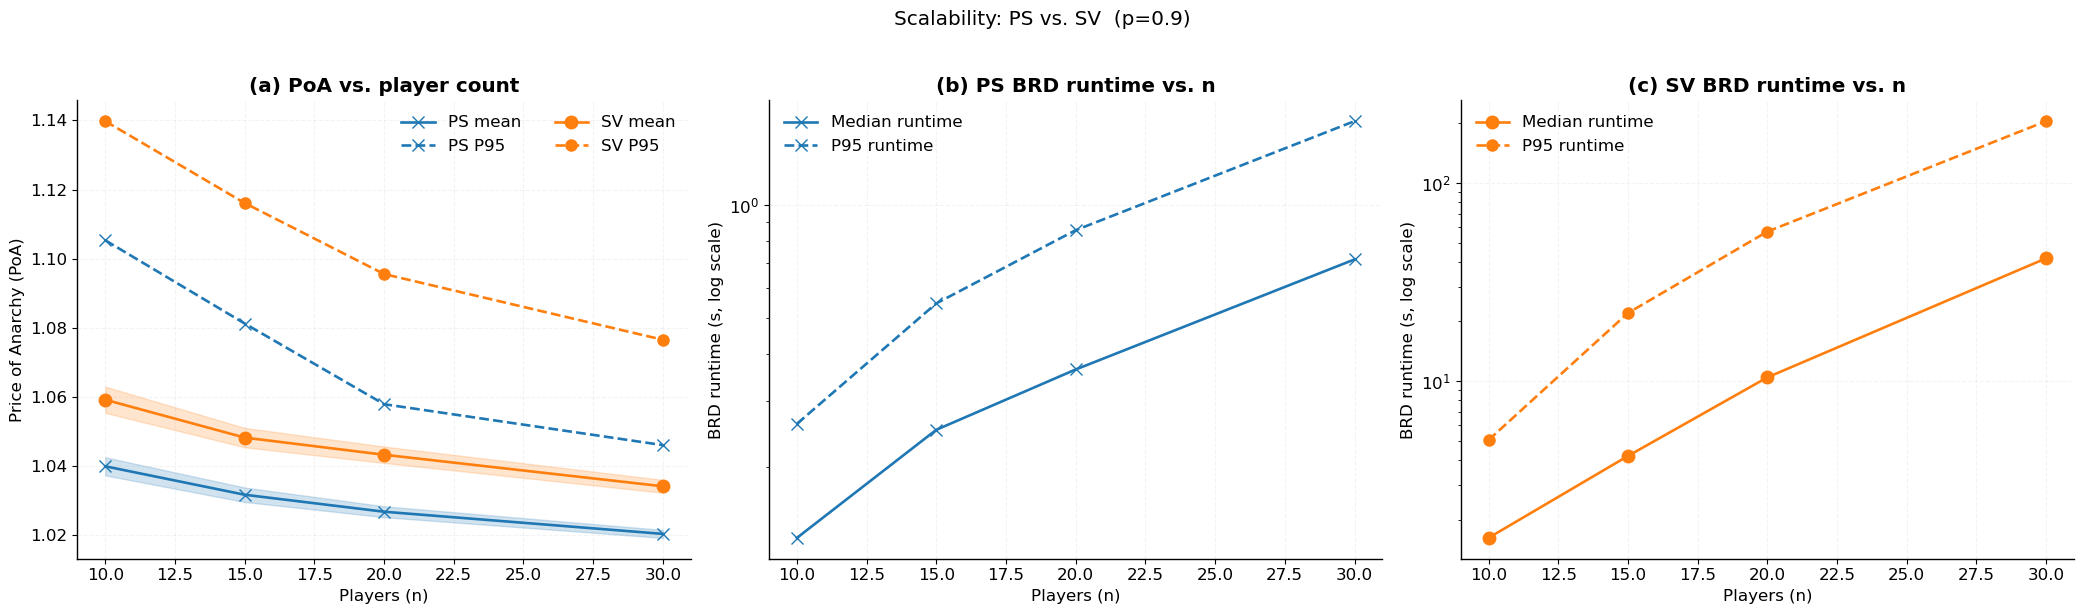

(<Figure size 2100x600 with 3 Axes>,
 (<Axes: title={'center': '(a) PoA vs. player count'}, xlabel='Players (n)', ylabel='Price of Anarchy (PoA)'>,
  <Axes: title={'center': '(b) PS BRD runtime vs. n'}, xlabel='Players (n)', ylabel='BRD runtime (s, log scale)'>,
  <Axes: title={'center': '(c) SV BRD runtime vs. n'}, xlabel='Players (n)', ylabel='BRD runtime (s, log scale)'>))

In [105]:
plot_scalability_panels(df_fast, title_tag="")


In [95]:
def create_detailed_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    """

    """
    if df.empty:
        print("Input DataFrame is empty. Cannot generate summary.")
        return pd.DataFrame()

    agg_functions = {
        'poa': ['mean', lambda x: x.quantile(0.95)],
        'time_brd_sec': ['median', lambda x: x.quantile(0.95)],
        'status': [lambda x: (x == 'CONVERGED').mean()],
        'n': ['count'] 
    }

  
    summary_df = df.groupby(['topology', 'rule', 'n', 'p']).agg(agg_functions)


    summary_df.columns = [
        'PoA (Mean)', 'PoA (P95)',
        'Runtime (Median, s)', 'Runtime (P95, s)',
        'Convergence Rate', 'Runs'
    ]
    
  
    summary_df['Convergence Rate'] = (summary_df['Convergence Rate'] * 100).map('{:.1f}%'.format)


    summary_df = summary_df.reset_index()


    column_order = [
        'topology', 'rule', 'n', 'p', 'PoA (Mean)', 'PoA (P95)', 
        'Runtime (Median, s)', 'Runtime (P95, s)'
    ]
    summary_df = summary_df[column_order]
    
    return summary_df

In [96]:
pd.set_option("display.max_rows", None)
create_detailed_summary_table(df_fast).head(100)

,topology,rule,n,p,PoA (Mean),PoA (P95),"Runtime (Median, s)","Runtime (P95, s)"
0,DegBound,PS,10,0.5,1.058463,1.180818,0.148948,0.213412
1,DegBound,PS,10,0.9,1.043608,1.119927,0.128966,0.217248
2,DegBound,PS,15,0.5,1.057522,1.181197,0.258391,0.453605
3,DegBound,PS,15,0.9,1.039371,1.118931,0.270437,0.418463
4,DegBound,PS,20,0.5,1.039027,1.126743,0.429905,0.704076
5,DegBound,PS,20,0.9,1.026553,1.082529,0.379417,0.659231
6,DegBound,PS,30,0.5,1.035649,1.103356,0.717629,1.085773
7,DegBound,PS,30,0.9,1.015940,1.047136,0.741655,1.190982
8,DegBound,SV,10,0.5,1.113718,1.326261,0.696079,1.192245
9,DegBound,SV,10,0.9,1.053882,1.206463,2.099333,4.451888


In [ ]:
import pandas as pd
import numpy as np

csv_path = "results_scalability/scalability_ps_sv_fast_*.csv"  

df = df_fast 
df = df[df["p"] == 0.9].copy()


df["poa"] = df["poa"].clip(lower=1.0)


df = df.rename(columns={
    "time_brd_sec":"runtime_sec",
    "PoA (Mean)":"PoA (Mean)",
    "PoA (P95)":"PoA (P95)",
    "Runtime (Median, s)":"Runtime (Median, s)",
    "Runtime (P95, s)":"Runtime (P95, s)"
})

def agg_block(g):
    return pd.Series({
        "PoA (Mean)": g["poa"].mean(),
        "PoA (P95)":  g["poa"].quantile(0.95),
        "Runtime (Median, s)": g["runtime_sec"].median(),
        "Runtime (P95, s)":    g["runtime_sec"].quantile(0.95),
        "runs": len(g)
    })

tbl_main = (
    df.groupby(["rule","n"], as_index=False)
      .apply(agg_block)
      .reset_index(drop=True)
      .sort_values(["rule","n"])
)


tbl_main_fmt = tbl_main.copy()
for c in ["PoA (Mean)","PoA (P95)"]:
    tbl_main_fmt[c] = tbl_main_fmt[c].map(lambda x: f"{x:.3f}")
for c in ["Runtime (Median, s)","Runtime (P95, s)"]:
    tbl_main_fmt[c] = tbl_main_fmt[c].map(lambda x: f"{x:.3f}")


tbl_main_fmt.to_csv("table_main_by_n_p09.csv", index=False)
with open("table_main_by_n_p09.tex","w") as f:
    f.write(tbl_main_fmt.to_latex(index=False, escape=False))

keep_n = {10,20,30}
df_snap = df[df["n"].isin(keep_n)].copy()

snap = (
    df_snap.groupby(["topology","rule","n"], as_index=False)
           .apply(agg_block).reset_index(drop=True)
)


snap_small = snap.pivot(index=["topology","n"], columns="rule",
                        values=["PoA (Mean)","Runtime (Median, s)"])

snap_small.columns = [f"{a} [{b}]" for a,b in snap_small.columns]
snap_small = snap_small.reset_index().sort_values(["topology","n"])


for c in snap_small.columns:
    if "PoA (Mean)" in c:
        snap_small[c] = snap_small[c].map(lambda x: f"{x:.3f}")
    if "Runtime (Median" in c:
        snap_small[c] = snap_small[c].map(lambda x: f"{x:.3f}")

snap_small.to_csv("table_snapshot_topology_p09.csv", index=False)
with open("table_snapshot_topology_p09.tex","w") as f:
    f.write(snap_small.to_latex(index=False, escape=False))


df30 = df[df["n"]==30].copy()
agg30 = df30.groupby(["topology","rule"], as_index=False).apply(agg_block).reset_index(drop=True)

ps30 = agg30[agg30["rule"]=="PS"][["topology","Runtime (Median, s)","PoA (Mean)"]]
sv30 = agg30[agg30["rule"]=="SV"][["topology","Runtime (Median, s)","PoA (Mean)"]]
ps30 = ps30.rename(columns={"Runtime (Median, s)":"PS Runtime (Median, s)",
                            "PoA (Mean)":"PS PoA (Mean)"})
sv30 = sv30.rename(columns={"Runtime (Median, s)":"SV Runtime (Median, s)",
                            "PoA (Mean)":"SV PoA (Mean)"})

ratio = ps30.merge(sv30, on="topology", how="inner")
ratio["Runtime Ratio (SV/PS)"] = ratio["SV Runtime (Median, s)"]/ratio["PS Runtime (Median, s)"]


ratio = ratio.sort_values("Runtime Ratio (SV/PS)", ascending=False)


for c in ["PS Runtime (Median, s)","SV Runtime (Median, s)","Runtime Ratio (SV/PS)",
          "PS PoA (Mean)","SV PoA (Mean)"]:
    ratio[c] = ratio[c].map(lambda x: f"{x:.3f}")

ratio.to_csv("table_ratio_n30_p09.csv", index=False)
with open("table_ratio_n30_p09.tex","w") as f:
    f.write(ratio.to_latex(index=False, escape=False))


/var/folders/h2/n_cynpcs08q84g2y2qwvg3fw0000gn/T/ipykernel_55963/2439997679.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_block)
/var/folders/h2/n_cynpcs08q84g2y2qwvg3fw0000gn/T/ipykernel_55963/2439997679.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_block).reset_index(drop=True)
/var/folders/h2/n_cynpcs08q84g2y2qwvg3fw0000gn/T/ipykernel_55963/2439997679.py:81: Deprecatio